In [1]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
runs = [
    np.load(file, allow_pickle=True) for file in (
        '../data/QSCOUT/UCDavis_11_12_24_AllCodes/superstaq_mswap_all_probs_0.npy',
        '../data/QSCOUT/UCDavis_11_12_24_AllCodes/superstaq_mswap_all_probs_1.npy',
        '../data/QSCOUT/UCDavis_11_12_24_AllCodes/superstaq_mswap_all_probs_2.npy',
        '../data/QSCOUT/UCDavis_11_12_24_AllCodes/superstaq_mswap_all_probs_3.npy',
    )
]

# indices into each timestep results
states = {
    "|1000>": 1,
    "|0100>": 2,
    "|0010>": 4,
    "|0001>": 8,
}

data = sum([pd.DataFrame({k: [row[v] for row in run] for k, v in states.items()}) for run in runs]) / len(runs)
qscout_not_normed = pd.DataFrame({"Emitter 1": data["|1000>"], "Emitter 2": data["|0100>"], "Emitter 3": data["|0010>"]})
data_normed = data.divide(data.sum(axis=1), axis=0)
qscout = pd.DataFrame({"Emitter 1": data_normed["|1000>"], "Emitter 2": (data_normed["|0100>"] + data_normed["|0010>"]) / 2})

0.09855882352941177

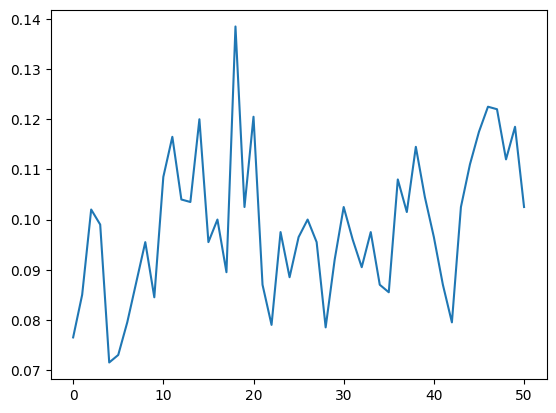

In [3]:
plt.plot((1 - data.sum(axis=1)).tolist())
(1 - data.sum(axis=1)).mean()

In [44]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [45]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

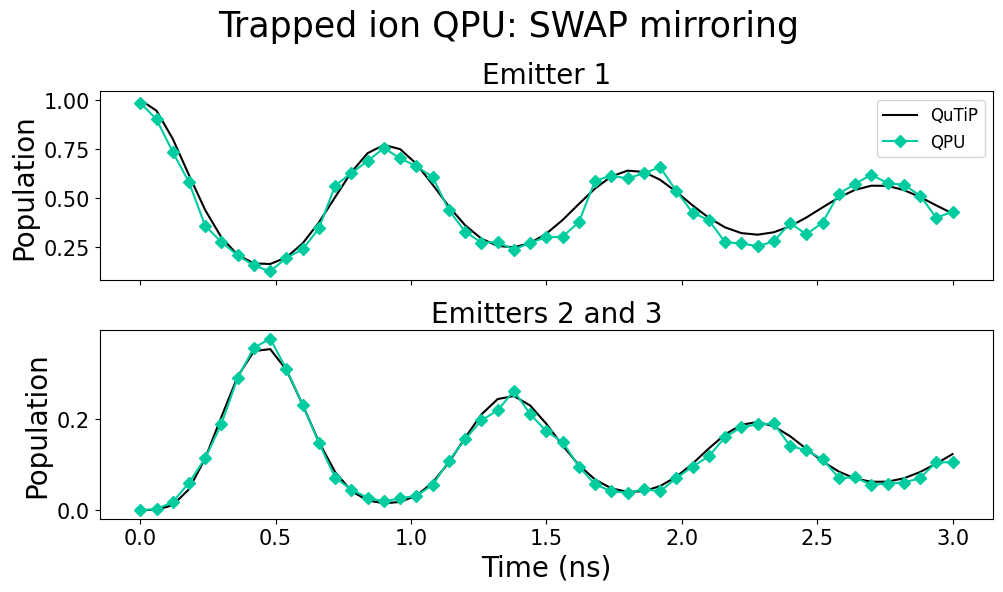

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].set_title("Emitter 1", fontsize=20)
axes[0].plot(qutip_results.index, qutip_results["Emitter 1"], label="QuTiP", color='black')
axes[0].plot(times, qscout["Emitter 1"], marker='D', label="QPU", color='#00cc9f')
axes[0].set_ylabel("Population", fontsize=20)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].set_xticklabels([])

axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].plot(qutip_results.index, qutip_results["Emitter 2"], label="QuTiP", color='black')
axes[1].plot(times, qscout["Emitter 2"], marker='D', label="QPU", color='#00cc9f')

axes[1].set_ylabel("Population", fontsize=20)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)

axes[1].set_xlabel("Time (ns)", fontsize=20)

fig.suptitle("Trapped ion QPU: SWAP mirroring", fontsize=25)
plt.tight_layout()

In [47]:
fig.savefig("../figures/QSCOUT_mirror_swaps.eps")

In [48]:
from errorbars import calculate_mae_uncertainty, write_results_to_file

####### MAE for postselected data

exp = qscout["Emitter 1"]
thy = qutip_results["Emitter 1"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 1", condition="Mirror SWAPs (postselected)")

#######

exp = qscout["Emitter 2"]
thy = qutip_results["Emitter 2"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 2", condition="Mirror SWAPs (postselected)")

####### MAE for NON-postselected data

exp = qscout_not_normed["Emitter 1"]
thy = qutip_results["Emitter 1"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 1", condition="Mirror SWAPs (non-postselected)")

#######

exp = qscout_not_normed["Emitter 2"]
thy = qutip_results["Emitter 2"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 2", condition="Mirror SWAPs (non-postselected)")

exp = qscout_not_normed["Emitter 3"]
thy = qutip_results["Emitter 3"]
results = calculate_mae_uncertainty(exp, thy)
write_results_to_file(results, processor="QSCOUT", emitter="Emitter 3", condition="Mirror SWAPs (non-postselected)")